In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy.stats import norm
from scipy.special import factorial
from tqdm import tqdm

In [60]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [61]:
# Reading channels
data = pd.read_csv('datos.csv',sep=',')
# Para el calculo de la significancia el numero de observaciones se espera que sea
# El numero de eventos de background + la señal y estamos buscando 
# Minimizar la probabilidad de en caso de observar s+b, no sea descrito por la hipotesis nula
s = np.array(data.s)
b = np.array(data.b)
n = s+b
N = n.shape[0]
data

,n,b,s
0,105,100,10


In [62]:
# debe ser s+b
n

array([110])

In [63]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [64]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [65]:
def GetObsJointLnQ(LnQ,mu):

    Q = 0.
    
    for c in range(N):
            Q += LnQ( n[c], b[c], s[c], mu )

    return Q

In [66]:
# Con significancia
Qobs = GetObsJointLnQ(GetLnQ,1.0)
Qobs

-0.9682395569514846

In [69]:
def Sampler(mu, Ntoys = int(1e5)):

    q0 = np.zeros(Ntoys)
 
    for i in tqdm(range(Ntoys)):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
    
    return q0

In [70]:
q0 =  Sampler(1.)

100%|██████████████████████████████████████████| 100000/100000 [00:02<00:00, 47646.75it/s]


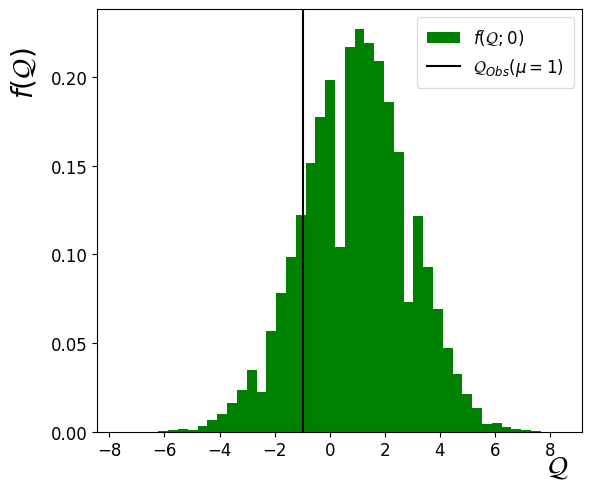

In [71]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(q0,bins=45,color='green',density=True,label=r'$f(\mathcal{Q};0)$')
plt.axvline(x=Qobs,color='k',label=r'$\mathcal{Q}_{Obs}(\mu=1)$')
#plt.yscale('log')

# Label X
ax.set_xlabel(r'$\mathcal{Q}$')
ax.xaxis.set_label_coords(0.95,-0.05)

# Label Y
ax.set_ylabel(r'$f(\mathcal{Q})$')
ax.yaxis.set_label_coords(-0.12,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('Significance_Q.pdf')

In [72]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [73]:
p0 = GetPValue(q0,Qobs,Null = True)
#p1 = GetPValue(q1,Qobs,Null = False)
print(p0)

0.16994


In [74]:
Significancia = np.abs(norm.ppf(p0))
Significancia

0.9544023839488451

In [75]:
# Deberia ser similiar a 
S = np.sum(s)
B = np.sum(b)
S/np.sqrt(B+S)

0.9534625892455924